# An example of reference mapping using user-owned reference dataset

The pancreas dataset is used in this example. Please download it from https://drive.google.com/drive/folders/1s9XjcSiPC-FYV3VeHrEa7SeZetrthQVV?usp=sharing

In [ ]:
import json
import os
import sys
from pathlib import Path

import faiss
import numpy as np
import pandas as pd
from scipy.stats import mode
import scanpy as sc
import sklearn
import torch

sys.path.insert(0, "../")
import scgpt as scg
from scgpt import logger

# extra dependency for similarity search
try:
    import hnswlib

    hnswlib_imported = True
except ImportError:
    hnswlib_imported = False
    print(
        "hnswlib not installed! We highly recommend installing it for fast similarity search."
    )
    print("To install it, run: pip install hnswlib")

In [2]:
model_dir = Path("../save/scGPT_human")
adata = sc.read_h5ad("../data/annotation_pancreas/demo_train.h5ad")
cell_type_key = "Celltype"
gene_col = "index"

scGPT - INFO - match 2999/3000 genes in vocabulary of size 60697.


100%|██████████| 166/166 [00:31<00:00,  5.24it/s]


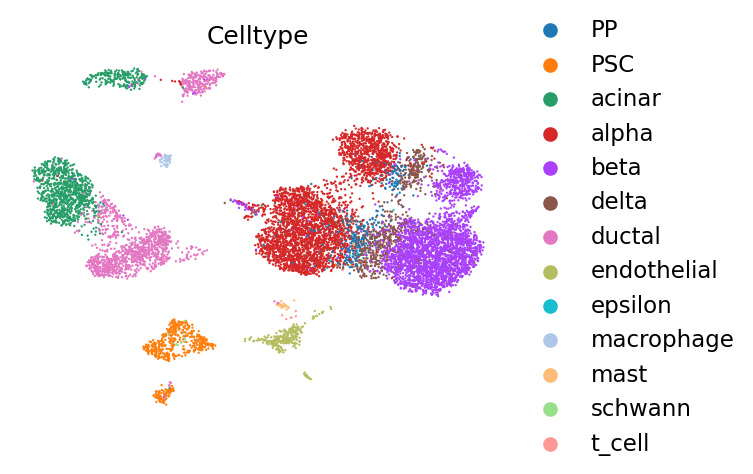

In [3]:
ref_embed_adata = scg.tasks.embed_data(
    adata,
    model_dir,
    cell_type_key=cell_type_key,
    gene_col=gene_col,
    batch_size=64,
    return_new_adata=True,
)

# Optional step to visualize the reference dataset using the embeddings
sc.pp.neighbors(ref_embed_adata, use_rep="X")
sc.tl.umap(ref_embed_adata)
sc.pl.umap(ref_embed_adata, color=cell_type_key, frameon=False, wspace=0.4)

In [4]:
test_adata = sc.read_h5ad("../data/annotation_pancreas/demo_test.h5ad")
test_embed_adata = scg.tasks.embed_data(
    test_adata,
    model_dir,
    cell_type_key=cell_type_key,
    gene_col=gene_col,
    batch_size=64,
    return_new_adata=True,
)

# # optional step to visualize the dataset
# sc.pp.neighbors(test_embed_adata, use_rep="X")
# sc.tl.umap(test_embed_adata)
# sc.pl.umap(test_embed_adata, color=cell_type_key, frameon=False, wspace=0.4)

scGPT - INFO - match 2999/3000 genes in vocabulary of size 60697.


100%|██████████| 66/66 [00:11<00:00,  5.60it/s]


## referrence mapping

In [5]:
# Those functions are only used when hnswlib is not installed
def cos_sim(a, b):
    sims = a @ b.T
    sims /= np.linalg.norm(a) * np.linalg.norm(b, axis=1) 
    return sims[0]

def l2_sim(a, b):
    sims = -np.linalg.norm(a - b, axis=1)
    return sims

def get_similar_vectors(vector, ref, top_k=10):
        # sims = cos_sim(vector, ref)
        sims = l2_sim(vector, ref)
        
        top_k_idx = np.argsort(sims)[::-1][:top_k]
        return top_k_idx, sims[top_k_idx]

def get_celltype(idx, adata):
    return adata.obs[cell_type_key][idx]

In [6]:
ref_cell_embeddings = ref_embed_adata.X
test_emebd = test_embed_adata.X

k = 10  # number of neighbors

if hnswlib_imported:
    # Declaring index, using most of the default parameters from https://github.com/nmslib/hnswlib
    p = hnswlib.Index(space = 'l2', dim = ref_cell_embeddings.shape[1]) # possible options are l2, cosine or ip
    p.init_index(max_elements = ref_cell_embeddings.shape[0], ef_construction = 200, M = 16)

    # Element insertion (can be called several times):
    p.add_items(ref_cell_embeddings, ids = np.arange(ref_cell_embeddings.shape[0]))

    # Controlling the recall by setting ef:
    p.set_ef(50) # ef should always be > k

    # Query dataset, k - number of closest elements (returns 2 numpy arrays)
    labels, distances = p.knn_query(test_emebd, k = k)

idx_list=[i for i in range(test_emebd.shape[0])]
preds = []
for k in idx_list:
    if hnswlib_imported:
        idx = labels[k]
    else:
        idx, sim = get_similar_vectors(test_emebd[k][np.newaxis, ...], ref_cell_embeddings)
    pred = mode(ref_embed_adata.obs[cell_type_key][idx], axis=0)
    preds.append(pred[0][0])
gt = test_adata.obs[cell_type_key].to_numpy()

sklearn.metrics.accuracy_score(gt, preds)

0.7807017543859649

In [ ]:
# optionally, the built index can be saved/loaded for future use
# if hnswlib_imported:
#     p.save_index("index.bin")
#     # the index can be loaded with
#     # p.load_index("index.bin", max_elements=...)

# Reference mapping using the whole 40 million cells collected from CellXGene

We have previously built the index for all the cells in normal or cancer samples, around 40 million cells in total. You can find the code to build the index at [build_atlas_index_faiss.py](build_atlas_index_faiss.py).
We applied careful tuning to eventually very well balance between the accuracy and efficiency. Now the actual building process takes less than 3 minutes and we choose to use only 16 bytes to store the vector per cell, which leads to 936 MB for the whole index of around 40 million cells.

Faiss is required to use the index. Please install it by following the instructions at http://github.com/facebookresearch/faiss

In [ ]:
from build_atlas_index_faiss import load_index

In [ ]:
use_gpu = faiss.get_num_gpus() > 0
index, meta_labels = load_index(
    index_dir="/scratch/hdd001/home/haotian/projects/cellxemb/all",
    use_config_file=False,
    use_gpu=use_gpu,
)
print(f"Loaded index with {index.ntotal} cells")


Loading index and meta from /scratch/hdd001/home/haotian/projects/cellxemb/all ...
Index loaded, num_embeddings: 40628904
Set nprobe from 128 to 128 for 16384 clusters
Loaded index with 40628904 cells


In [ ]:
%%time
k = 10
# test with the first 100 cells
distances, idx = index.search(test_emebd, k)

CPU times: user 227 ms, sys: 425 ms, total: 652 ms
Wall time: 114 ms


In [ ]:
matched_array = meta_labels[idx]
from scipy.stats import mode

voting = mode(matched_array, axis=1)[0]

In [ ]:
# find the endothelial cells
ids_m = np.where(gt == "endothelial")[0]
print(f"Found {len(ids_m)} endothelial cells")
print(f"Predicted cell types: {voting[ids_m]}")
print(f"Annotated cell types: {gt[ids_m]}")